# multiclass classification

<ipython-input-4-e2ce13de7cd9>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-4-e2ce13de7cd9>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', lut=n_class)


(-1.2, 1.2)

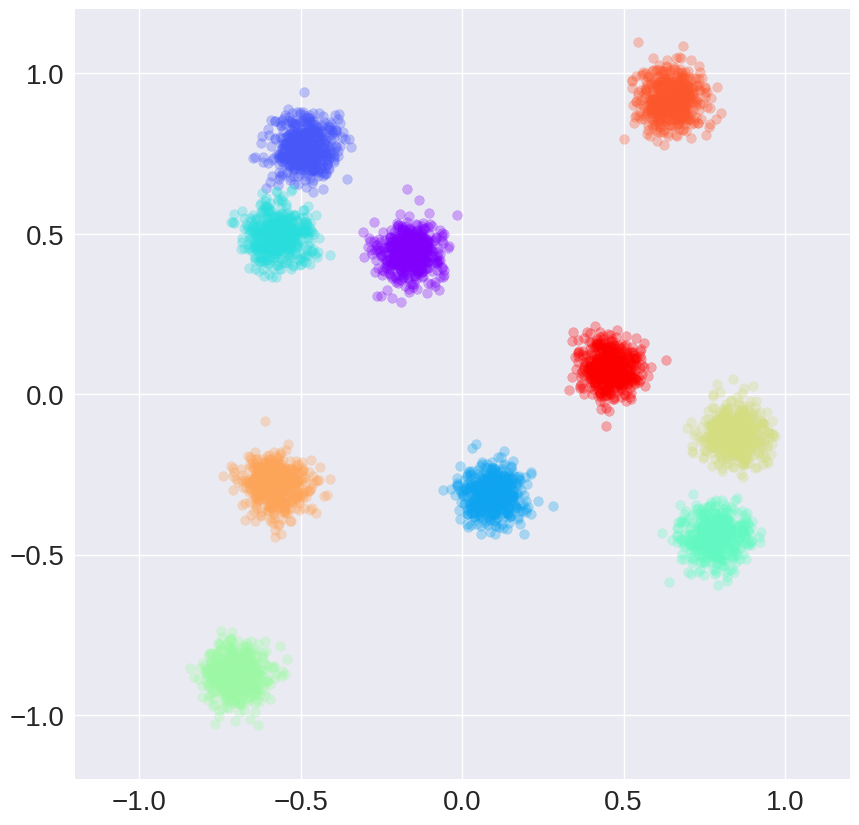

In [4]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored
np.random.seed(1)
plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# dataset generation
n_class, n_data = 10, 500
noise = 0.05

x_data = np.empty(shape=(0,2)) # N,2 이렇게 만들기 위해서
y_data = np.empty(shape=(0,1))

cmap = cm.get_cmap('rainbow', lut=n_class)
fig,ax = plt.subplots(figsize=(10,10))
for class_idx in range(n_class):
    center = np.random.uniform(-1,1,(2,))

    x1_data = center[0] + noise*np.random.normal(0,1,(n_data,1))
    x2_data = center[1] + noise*np.random.normal(0,1,(n_data,1))

    class_x_data = np.hstack((x1_data, x2_data))
    class_y_data = class_idx*np.ones((n_data,1))

    x_data = np.vstack((x_data, class_x_data)).astype(np.float32)
    y_data = np.vstack((y_data, class_y_data)).astype(np.int32)

    ax.scatter(x1_data, x2_data, color=cmap(class_idx), alpha=0.3)

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])


In [14]:
# tensorflow datasets
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_data, y_data))
train_ds = train_ds.shuffle(1000).batch(8)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(units=n_class))
model.add(Activation('softmax'))

## instantiate training object
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

loss_object = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=.01)

train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

## define trainer
@tf.function
def trainer():
    global train_ds, model, loss_object, optimizer
    global train_loss, train_acc

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(labels, predictions)


## define reporter
def training_reporter():
    global epoch
    global train_loss, train_acc

    print(colored('epoch', 'red', 'on_white'), epoch+1)
    template = 'Train Loss: {:.4f}\t Train Accuracy: {:.2f}%'
    print(template.format(train_loss.result(),
                          train_acc.result()*100))
    
    train_loss.reset_states()
    train_acc.reset_states()


## training
epochs = 50
for epoch in range(epochs):
    trainer()
    training_reporter()

epoch 1
Train Loss: 0.3791	 Train Accuracy: 92.72%
epoch 2
Train Loss: 0.0275	 Train Accuracy: 99.72%
epoch 3
Train Loss: 0.0088	 Train Accuracy: 99.90%
epoch 4
Train Loss: 0.0062	 Train Accuracy: 99.90%
epoch 5
Train Loss: 0.0050	 Train Accuracy: 99.88%
epoch 6
Train Loss: 0.0064	 Train Accuracy: 99.80%
epoch 7
Train Loss: 0.0044	 Train Accuracy: 99.84%
epoch 8
Train Loss: 0.0063	 Train Accuracy: 99.86%
epoch 9
Train Loss: 0.0036	 Train Accuracy: 99.86%
epoch 10
Train Loss: 0.0024	 Train Accuracy: 99.92%
epoch 11
Train Loss: 0.0041	 Train Accuracy: 99.90%
epoch 12
Train Loss: 0.0026	 Train Accuracy: 99.92%
epoch 13
Train Loss: 0.0053	 Train Accuracy: 99.84%
epoch 14
Train Loss: 0.0046	 Train Accuracy: 99.88%
epoch 15
Train Loss: 0.0104	 Train Accuracy: 99.78%
epoch 16
Train Loss: 0.0066	 Train Accuracy: 99.74%
epoch 17
Train Loss: 0.0051	 Train Accuracy: 99.82%
epoch 18
Train Loss: 0.0040	 Train Accuracy: 99.88%
epoch 19
Train Loss: 0.0021	 Train Accuracy: 99.90%
epoch 20
Train Loss: 

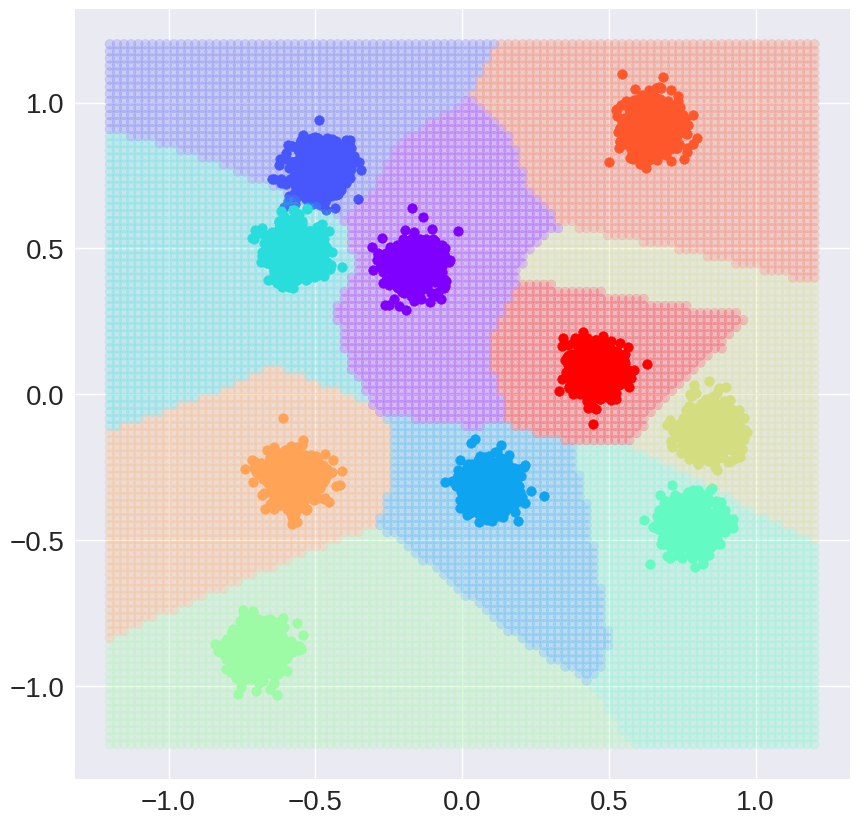

In [15]:
# decision bounary test

x1_test = np.linspace(-1.2, 1.2, 100).astype(np.float32)
x2_test = np.linspace(-1.2, 1.2, 100).astype(np.float32)

X1, X2 = np.meshgrid(x1_test, x2_test) # (100,100)이기 때문에 flatten()
x1_test, x2_test = X1.flatten(), X2.flatten()

x_test = np.hstack((x1_test.reshape(-1,1),
                   x2_test.reshape(-1,1)))
y_test = model(x_test).numpy()
predictions = np.argmax(y_test, axis=1) # index를 만들어 낼 수 있음. 

cdict = {i:cmap(i) for i in range(n_class)}
color_arr = [cdict[pred] for pred in predictions]

fig, ax = plt.subplots(figsize=(10,10))
for class_idx in range(n_class):
    ax.scatter(x_data[class_idx*n_data: (class_idx+1)*n_data, 0],
               x_data[class_idx*n_data: (class_idx+1)*n_data, 1],
               color=cmap(class_idx))
ax.scatter(x1_test, x2_test, c=color_arr, alpha=0.2) # decision boundary 시각화 

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# MNIST classification

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Activation

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

In [36]:
def get_mnist_ds():
    (train_validation_ds, test_ds), ds_info = tfds.load(name='mnist',
                                                        shuffle_files=True,
                                                        as_supervised=True,
                                                        split=['train', 'test'],
                                                        with_info=True)
    
    n_train_validation = ds_info.splits['train'].num_examples

    train_ratio=.8
    n_train = int(n_train_validation * train_ratio)
    n_validation = n_train_validation - n_train

    train_ds = train_validation_ds.take(n_train)
    remaining_ds = train_validation_ds.skip(n_train)
    validation_ds = remaining_ds.take(n_validation)

    return train_ds, validation_ds, test_ds


def standardization(train_batch_size, test_batch_size):
    global train_ds, validation_ds, test_ds

    def stnd(images, labels):
        images = tf.cast(images, tf.float32) / 255.
        return (images, labels)

    train_ds = train_ds.map(stnd).shuffle(1000).batch(train_batch_size)
    validation_ds = validation_ds.map(stnd).batch(test_batch_size)
    test_ds = test_ds.map(stnd).batch(test_batch_size)


class MNIST_Classifier(Model):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()

        self.flatten = Flatten()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x


def load_metrics():
    global train_loss, train_acc
    global validation_loss, validation_acc
    global test_loss, test_acc

    train_loss = Mean()
    validation_loss = Mean()
    test_loss = Mean()

    train_acc = SparseCategoricalAccuracy()
    validation_acc = SparseCategoricalAccuracy()
    test_acc = SparseCategoricalAccuracy()

@tf.function
def trainer():
    global train_ds, model, loss_object, opitmizer
    global train_loss, train_acc

    for images, labels in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(labels, predictions)

@tf.function
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc

    for images, labels in validation_ds:

        predictions = model(images)
        loss = loss_object(labels, predictions)

        validation_loss(loss)
        validation_acc(labels, predictions)

@tf.function
def tester():
    global test_ds, model, loss_object
    global test_loss, test_acc

    for images, labels in test_ds:

        predictions = model(images)
        loss = loss_object(labels, predictions)

        test_loss(loss)
        test_acc(labels, predictions)

    # print문을 @tf.function 과 같이 쓰면 작동이 잘 안됨.  
    # template = 'Test loss : {:.4f}\t Test Accuracy: {:.2f}%\n'
    # print(template.format(test_loss.result(), test_acc.result())
    

def train_reporter():
    global epoch
    global train_loss, train_ac
    global validation_loss, validation_acc

    print(colored('epoch', 'red', 'on_white'), epoch+1)
    template = 'Train loss : {:.4f}\t Train Accuracy: {:.2f}%\n' + \
                'Validation loss : {:.4f}\t Validation Accuracy: {:.2f}%\n'
    print(template.format(train_loss.result(),
                          train_acc.result()*100,
                          validation_loss.result(),
                          validation_acc.result()*100))
    train_acc.reset_states()
    train_loss.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()


epochs = 10
lr = 0.001
train_batch_size = 16
test_batch_size = 32

train_ds, validation_ds, test_ds = get_mnist_ds()
standardization(train_batch_size, test_batch_size)

model = MNIST_Classifier()
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=lr)

load_metrics()

for epoch in range(epochs):
    trainer()
    validation()
    train_reporter()

tester()

epoch 1
Train loss : 1.5592	 Train Accuracy: 59.18%
Validation loss : 0.9967	 Validation Accuracy: 79.40%

epoch 2
Train loss : 0.7723	 Train Accuracy: 82.88%
Validation loss : 0.6362	 Validation Accuracy: 85.09%

epoch 3
Train loss : 0.5637	 Train Accuracy: 86.18%
Validation loss : 0.5159	 Validation Accuracy: 87.22%

epoch 4
Train loss : 0.4793	 Train Accuracy: 87.57%
Validation loss : 0.4561	 Validation Accuracy: 88.26%

epoch 5
Train loss : 0.4326	 Train Accuracy: 88.51%
Validation loss : 0.4206	 Validation Accuracy: 88.92%

epoch 6
Train loss : 0.4024	 Train Accuracy: 89.09%
Validation loss : 0.3953	 Validation Accuracy: 89.53%

epoch 7
Train loss : 0.3807	 Train Accuracy: 89.54%
Validation loss : 0.3775	 Validation Accuracy: 89.82%

epoch 8
Train loss : 0.3641	 Train Accuracy: 89.88%
Validation loss : 0.3635	 Validation Accuracy: 90.14%

epoch 9
Train loss : 0.3508	 Train Accuracy: 90.17%
Validation loss : 0.3516	 Validation Accuracy: 90.46%

epoch 10
Train loss : 0.3396	 Train A

# Model Build and Summary

In [ ]:
# model.summary
# model.train_parameter
# model.gradient

In [46]:
import os
import json
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import InputLayer

# ram을 다 잡아먹지 않게 하기 위해
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [47]:
# session 초기화
tf.keras.backend.clear_session()

In [48]:
model = Sequential()
model.add(InputLayer(input_shape=(28,28,1))) # batch size는 포함시키지 않음. 
model.add(Flatten())
model.add(Dense(units=10)) # 784*10 + 10 ==> 7850
model.add(Activation('relu'))
model.add(Dense(units=2)) # 10*2 + 2 ==> 22 
model.add(Activation('softmax'))

# model.build(input_shape=(None, 28, 28, 1)) # 첫번째 차원은 배치 사이즈

model.build()

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 7,872
Trainable params: 7,872
Non-trainable params: 0
_________________________________________________________________


In [50]:
class TestModel(Model):
    def __init__(self):
        super(TestModel, self).__init__()

        self.flatten = Flatten()
        self.d1 = Dense(units=10)
        self.d1_act = Activation('relu')
        self.d2 = Dense(units=2)
        self.d2_act = Activation('softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d1_act(x)
        x = self.d2(x)
        x = self.d2_act(x)
        return x

model = TestModel()
print(model.built)
# model.build(input_shape=(None, 28, 28, 1)) # subclassing은 이렇게 해주는 것이 좋음. 
# model.summary()


False


In [52]:
model = Sequential()
model.add(Flatten())
model.add(Dense(units=10))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))

print(model.built)
test_img = tf.random.normal(shape=(1,28,28,1))
model(test_img)
print(model.built)

False
True


In [54]:
# CNN 예시
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

model = Sequential()

model.add(Conv2D(filters=10, kernel_size=(3,3), padding='valid',
                 name='conv_1'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, 
                       name='conv_1_maxpool'))
model.add(Activation('relu',
                     name='conv_1_act'))

model.add(Conv2D(filters=10, kernel_size=(3,3), padding='valid',
                 name='conv_2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, 
                       name='conv_2_maxpool'))
model.add(Activation('relu',
                     name='conv_2_act'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu', name='dense_1'))
model.add(Dense(units=10, activation='softmax', name='dense_2'))

# model build
model.build(input_shape=(None, 28, 28, 1))
model.summary()

print(model.layers) # layers object를 객체를 받을 수 있음. 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 conv_1_maxpool (MaxPooling2  (None, 13, 13, 10)       0         
 D)                                                              
                                                                 
 conv_1_act (Activation)     (None, 13, 13, 10)        0         
                                                                 
 conv_2 (Conv2D)             (None, 11, 11, 10)        910       
                                                                 
 conv_2_maxpool (MaxPooling2  (None, 5, 5, 10)         0         
 D)                                                              
                                                                 
 conv_2_act (Activation)     (None, 5, 5, 10)         